Objective
Cluster customer reviews (from name) to discover underlying groupings or themes without using labels.

### 1. Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  # For dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.manifold import TSNE

### 2. Load Dataset

In [32]:
df = pd.read_csv("data/cleaned_amazon_reviews_final.csv")
df = df.dropna(subset=['name'])

### 3. Text Vectorization (TF-IDF)

In [33]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['name'])

### 4. Dimensionality Reduction 

In [34]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

### 5. Choosing Number of Clusters (Elbow + Silhouette)

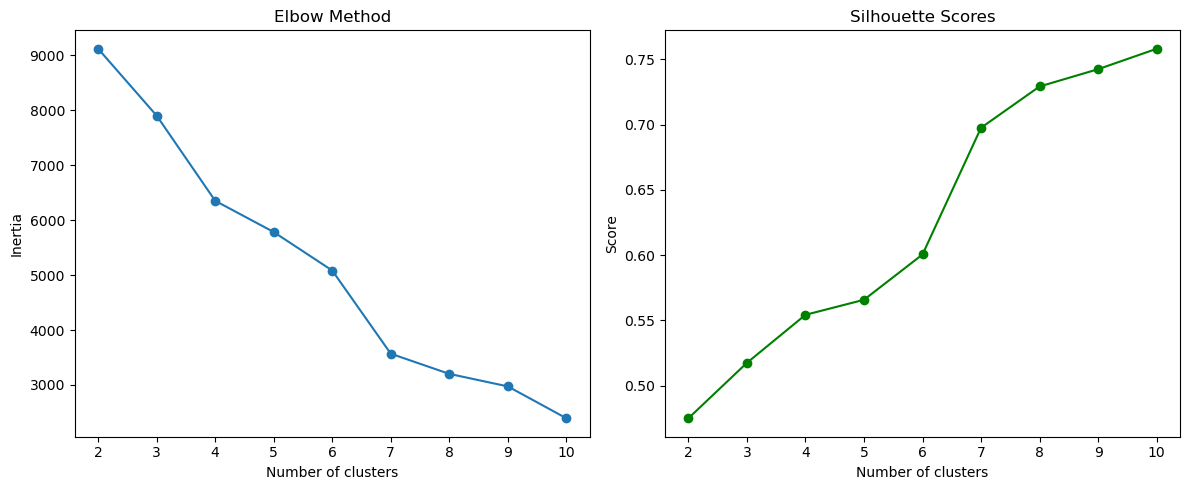

In [35]:
inertia = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_reduced)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_reduced, km.labels_))

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


#### Interpretation:

Elbow Method (Left Plot):
- The inertia decreases steadily, but there’s a noticeable "elbow" around k = 5 to 7.
- After k = 7, the gain (reduction in inertia) becomes marginal — a classic sign of diminishing returns.

Silhouette Score (Right Plot):
- Surprisingly, the best silhouette score is at k = 2 (≈ 0.14).
- After that, the scores drop significantly and remain low — below 0.05, which typically indicates weak cluster separation.

#### Toughts:
- KMeans is struggling to find well-separated clusters in this dataset — this is typical for high-dimensional text data with noisy or similar content.
- k = 2 has the highest silhouette score, but may not be semantically meaningful (might just split positive vs. neutral/negative sentiment).
- k = 5 to 7 is reasonable from the inertia curve, but those clusters are overlapping in semantic space.

### 6. Fit Final KMeans Model

In [36]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_reduced)


### 7. Analyze Clusters
WordCloud per Cluster:

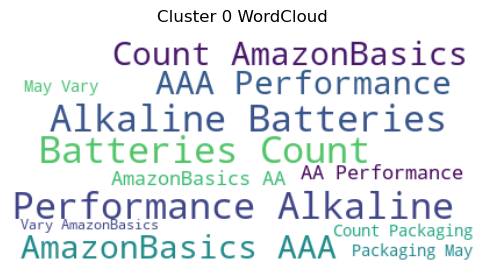

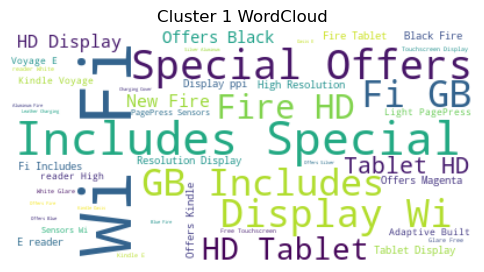

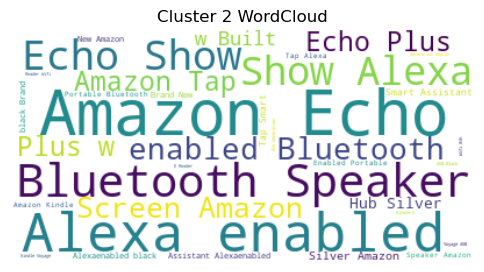

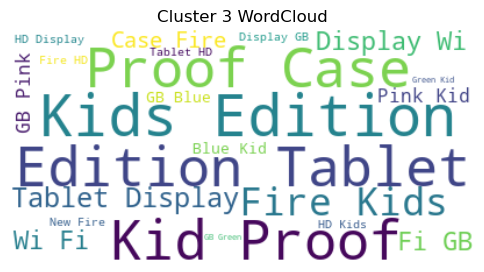

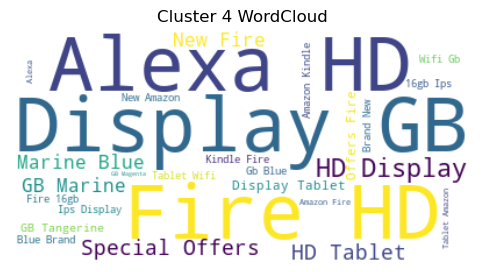

In [37]:
for i in range(best_k):
    cluster_text = " ".join(df[df['cluster'] == i]['name'])
    wordcloud = WordCloud(background_color='white').generate(cluster_text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {i} WordCloud")
    plt.show()


Top Words per Cluster:

In [38]:
terms = vectorizer.get_feature_names_out()
for i in range(best_k):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    print(f"\nCluster {i} top words:")
    print([terms[index] for index in top_indices])



Cluster 0 top words:
['10', '15', 'aaa', 'bag', '17', 'accordion', 'accelerated', '2016', '16gb', '32']

Cluster 1 top words:
['100', '1st', '2016', '23', '36', '32', '2nd', '400', '4k', '36x23x25']

Cluster 2 top words:
['16', '200', '17', '100', '42x28x30', '2016', '2nd', '9w', '3g', '50']

Cluster 3 top words:
['11', '100', '16', '16gb', '2016', '17', '2nd', '4gb', '42x28x30', '200']

Cluster 4 top words:
['100', '16gb', '16', '1st', '200', '17', '300', '400', '8th', '4gb']


#### t-SNE Visualization of Clusters on SVD

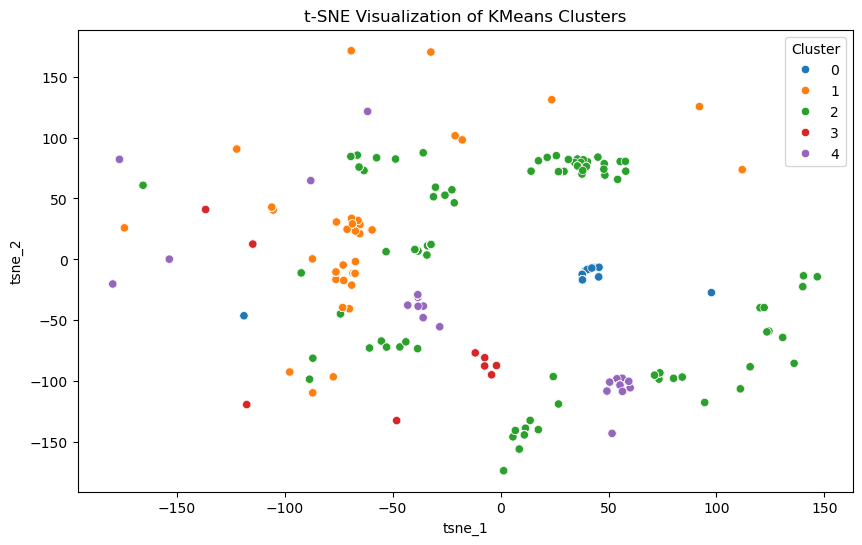

In [39]:

import matplotlib.pyplot as plt
import seaborn as sns

# Use SVD output (X_reduced) if available, or use X_tfidf_full
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)  # or use X_tfidf_full.toarray()

# Add to DataFrame
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='tab10')
plt.title('t-SNE Visualization of KMeans Clusters')
plt.legend(title='Cluster')
plt.show()


## Top Terms per Cluster (Grouped TF-IDF)

In [40]:
# Vectorize the full cleaned text
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf_full = vectorizer.fit_transform(df['name'])
tfidf_df = pd.DataFrame(X_tfidf_full.toarray(), columns=vectorizer.get_feature_names_out())

# Add cluster label to each row
tfidf_df['cluster'] = df['cluster'].values

# Group by cluster and compute mean TF-IDF per word
cluster_tfidf = tfidf_df.groupby('cluster').mean()

# Display top words per cluster
top_n = 10
for cluster_id in cluster_tfidf.index:
    top_words = cluster_tfidf.loc[cluster_id].sort_values(ascending=False).head(top_n)
    print(f"\nCluster {cluster_id} top words :")
    print(top_words)



Cluster 0 top words :
alkaline        0.343002
performance     0.343002
batteries       0.343002
count           0.343002
amazonbasics    0.341026
36              0.338665
aaa             0.338665
48              0.070788
aa              0.070788
vary            0.070788
Name: 0, dtype: float64

Cluster 1 top words :
hd          0.341037
includes    0.265394
special     0.235978
offers      0.235978
wi          0.228906
fi          0.228906
black       0.198755
display     0.195620
16          0.188494
gb          0.184952
Name: 1, dtype: float64

Cluster 2 top words :
amazon       0.268830
echo         0.212846
bluetooth    0.163700
speaker      0.163578
enabled      0.163330
screen       0.136439
alexa        0.124070
hub          0.113719
plus         0.113719
silver       0.107731
Name: 2, dtype: float64

Cluster 3 top words :
proof      0.326961
kid        0.326961
kids       0.326961
edition    0.326823
case       0.326684
pink       0.212363
gb         0.201540
tablet     0.199

### Cluster Size + Review Length Distribution

C:\Users\jeand\AppData\Local\Temp\ipykernel_36456\2503831138.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='tab10')


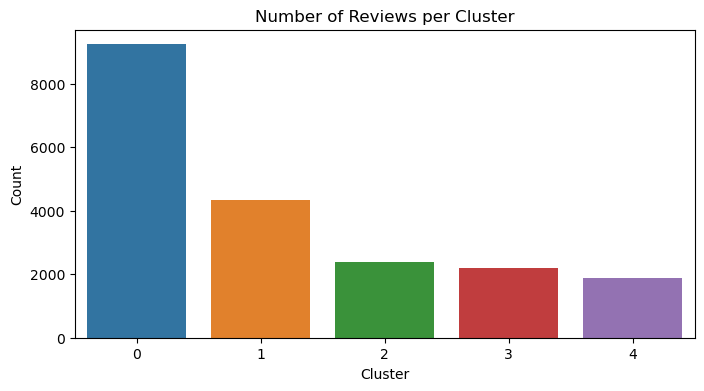

C:\Users\jeand\AppData\Local\Temp\ipykernel_36456\2503831138.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='review_length', palette='Set2')


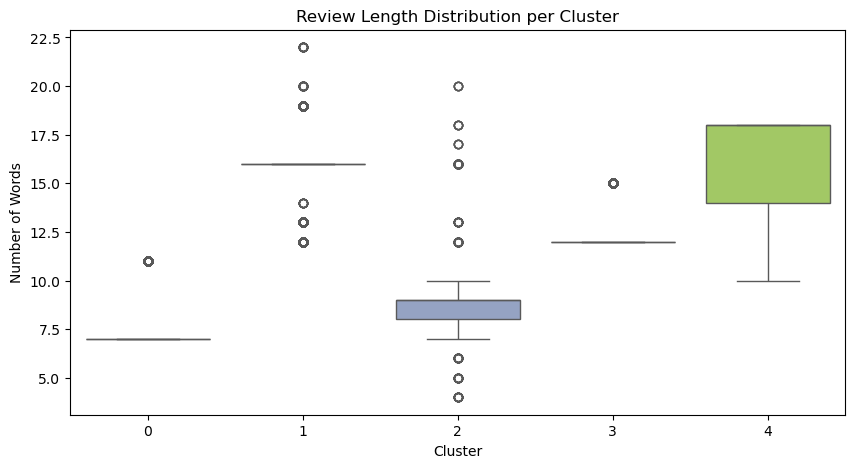

In [41]:
# Cluster Size Plot

plt.figure(figsize=(8, 4))
sns.countplot(x='cluster', data=df, palette='tab10')
plt.title('Number of Reviews per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Review Length per Cluster
df['review_length'] = df['name'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='cluster', y='review_length', palette='Set2')
plt.title('Review Length Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Words')
plt.show()


### UMAP for Faster / Better Cluster Projection

c:\Users\jeand\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


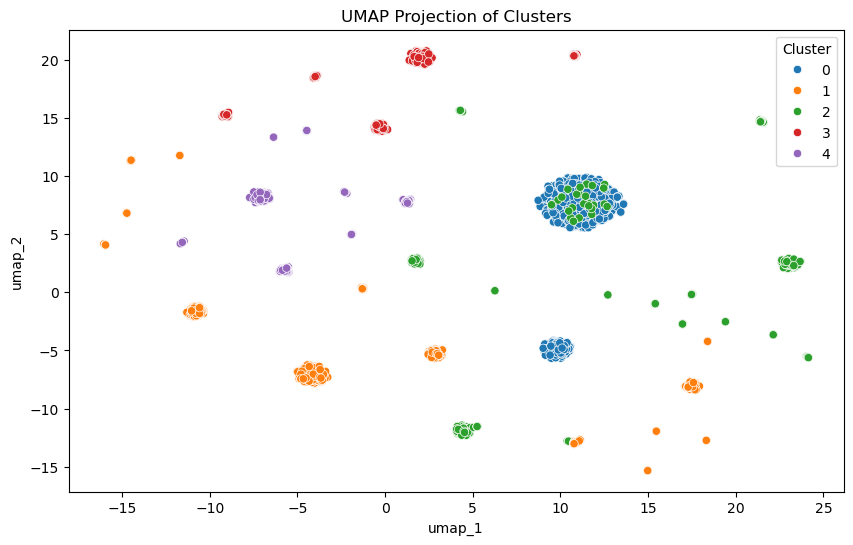

In [42]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_reduced)  # Use SVD-reduced data

df['umap_1'] = X_umap[:, 0]
df['umap_2'] = X_umap[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='umap_1', y='umap_2', hue='cluster', palette='tab10')
plt.title('UMAP Projection of Clusters')
plt.legend(title='Cluster')
plt.show()


### Summary Table Per Cluster (Descriptive Report)

In [43]:
# Create summary stats
# Basic summary first (counts and avg lengths)
cluster_summary = df.groupby('cluster').agg(
    count=('name', 'count'),
    avg_length=('review_length', 'mean')
).reset_index()

# Now compute top_words separately
top_words_list = []
for cluster_id in cluster_summary['cluster']:
    top_words = cluster_tfidf.loc[cluster_id].sort_values(ascending=False).head(5).index
    top_words_list.append(" | ".join(top_words))

cluster_summary['top_words'] = top_words_list

# Display
from IPython.display import display
display(cluster_summary)



,cluster,count,avg_length,top_words
0,0,9242,7.646613,alkaline | performance | batteries | count | a...
1,1,4342,15.582220,hd | includes | special | offers | wi
2,2,2379,8.757041,amazon | echo | bluetooth | speaker | enabled
3,3,2206,12.576609,proof | kid | kids | edition | case
4,4,1894,16.124076,hd | alexa | marine | blue | tablet


### Comparing Clusters with Sentiment Labels

In [44]:
# Cross-tab between clusters and sentiment labels
pd.crosstab(df['cluster'], df['label'])

label,0,1,2
cluster,,,
0,956,442,7844
1,93,150,4099
2,64,98,2217
3,72,113,2021
4,39,73,1782


In [45]:
pd.crosstab(df['cluster'], df['label'], normalize='index').round(2)

label,0,1,2
cluster,,,
0,0.10,0.05,0.85
1,0.02,0.03,0.94
2,0.03,0.04,0.93
3,0.03,0.05,0.92
4,0.02,0.04,0.94


### Exporting Cluster Summaries as JSON

In [46]:
cluster_summary.to_json("clusters_summaries_json/kmeans_summary.json", orient="records", indent=2)

In [47]:
cluster_summary

,cluster,count,avg_length,top_words
0,0,9242,7.646613,alkaline | performance | batteries | count | a...
1,1,4342,15.582220,hd | includes | special | offers | wi
2,2,2379,8.757041,amazon | echo | bluetooth | speaker | enabled
3,3,2206,12.576609,proof | kid | kids | edition | case
4,4,1894,16.124076,hd | alexa | marine | blue | tablet
